In [1]:
import sys

sys.path.insert(0,'../sib/')
import csv
import sib
import os
import numpy as np
import pandas as pd
import sklearn.metrics as mm
# sir_inference imports
from sir_model import FastProximityModel, patient_zeros_states
from ranking import csr_to_list
import os.path
from os import path
N=2000
#N = 5000
#N = 100
## new try with 100 spreaders
N_patient_zero = 10;
#N_patient_zero = 1;
lamb_load = 0.05;
lamb = 0.05
mu = 0.02;
scale=1.0; # Easy Case
T=120;
seed=5;
location="networks"
# SIR parameters
t1 = 10;
#seed=int();


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from pathlib import Path
import pandas as pd

fold_net = Path(location)
positions_file = "pos_proximity_N%dK_s%.1f_T%d_lamb%.2f_s%d.csv"%(N/1000,scale,T,lamb,seed)
pos_nodes = pd.read_csv(fold_net/positions_file)

In [3]:
## import sys
from time import time
import numpy as np
import pandas as pd
import os.path
from os import path
from scenario import Scenario
from sir_model import EpidemicModel, patient_zeros_states, symptomatic_individuals
from ranking import RANKINGS
log_fname="interactions_proximity_N%dK_s%.1f_T%d_lamb%.2f_s%d.csv"%(N/1000,scale,T,lamb_load,seed)
csv_file=location+"/"+log_fname
print("seed = %d"%seed, flush=True)
np.random.seed(seed);
if path.exists(csv_file): print("Loading model from %s"%csv_file)
else:
    raise ValueError("Could not find the file! Was looking for \n "+csv_file+"\n Bye-Bye")
    sys.exit()
print("Load Proximity model", flush=True)

tic = time()
model = EpidemicModel(initial_states=np.zeros(N), x_pos=np.zeros(N), y_pos=np.zeros(N))
model.load_transmissions(csv_file, new_lambda = lamb)
model.recover_probas = mu*np.ones(N)
print(f"Loading took {time()-tic:.1f}s",flush=True)
model.initial_states = patient_zeros_states(N, N_patient_zero)
model.time_evolution(model.recover_probas, model.transmissions, print_every=50)
t_max = len(model.transmissions)
print("Save plain dynamics", flush=True)
db = pd.DataFrame()
db["S"] = np.sum(model.states==0,axis=1)
db["I"] = np.sum(model.states==1,axis=1)
db["R"] = np.sum(model.states==2,axis=1)
db.to_csv("csv/Proximity_N%dK_T%d_s1_pz%d_mu%.2f_l%.2f_seed%d.csv"%(N/1000,T,N_patient_zero,mu,lamb,seed),
          index=False, sep="\t")

all_states = model.states
model.initial_states = model.states[t1]
model.states = model.states[t1:]
model.transmissions = model.transmissions[t1:]
model.pruned_transmissions = model.transmissions.copy()

seed = 5
Loading model from networks/interactions_proximity_N2K_s1.0_T120_lamb0.05_s5.csv
Load Proximity model
Loading transmissions from networks/interactions_proximity_N2K_s1.0_T120_lamb0.05_s5.csv
Loading took 1.8s
Running SIR simulation
t = 0 / 120
t = 50 / 120
t = 100 / 120
Save plain dynamics


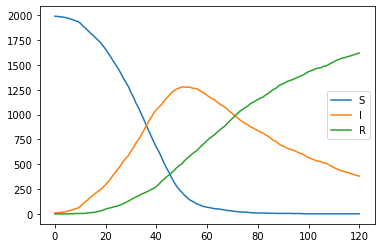

In [4]:
db.plot()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

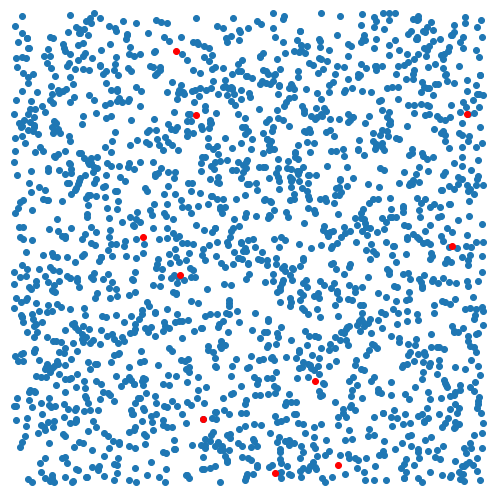

In [6]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig,ax = plt.subplots(figsize=(7,7), frameon=False)
lim=0.6
ax.set(xlim=(pos_nodes.x.max()+lim, pos_nodes.x.min()-lim),
      ylim=(pos_nodes.y.max()+lim, pos_nodes.y.min()-lim))

#fig.patch.set_visible(False)
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
time = 0


def get_nodes(t):
    return {i:np.where(all_states[t]==i)[0] for i in range(3)}
def setup_start(ax, pos_nodes, nodes_keys, colors, fn_get_nodes):

    nodes_idx = fn_get_nodes(0)
    paths = {}
    for nk, color in zip(nodes_keys, colors):
        g=pos_nodes.iloc[nodes_idx[nk]]
        paths[nk] = ax.scatter(g["x"],g["y"], color=color)
    return paths

paths = setup_start(ax, pos_nodes,  [0,1,2], colors=[None, "red","green"],
                   fn_get_nodes=get_nodes)
def animate(time):
    nodes_idx = get_nodes(time)
    for k in [0,1,2]:
        g=pos_nodes.iloc[nodes_idx[k]]
        paths[k].set_offsets(np.c_[g["x"].values, g["y"].values])

anim = FuncAnimation(
    fig, animate, interval=100, frames=T-1, cache_frame_data=False)

plt.draw()
plt.show()

#anim.save("sim.mov", codec="h263p", bitrate=-1)
#anim.save("sim.webm", codec="libvpx-vp9")
writer=PillowWriter(fps=15)
anim.save("sim.gif",writer=writer)


In [7]:
traces = {}
ranks_status ={}

In [8]:
def save_status(scenario, name):
    ranks_status[name]=scenario.status
    ranks_status[name]["t"]+=t1

In [9]:
tau = 5
# trac parameters
trac_tau = tau;
trac_lambd = lamb;
# MF parameters
MF_tau = tau;
MF_delta = 15;
# observation parameters
n_ranking = 40
p_untracked=0
#seed = int(sys.argv[2]);
#seeds for running [32,123,456]
#seed=int(sys.argv[1]);
################################################

intervention_options=dict(quarantine_time=T)
observation_options=dict(n_random=0,n_infected=0,n_ranking=n_ranking, p_symptomatic=0.5, tau=5, p_untracked=p_untracked)

In [10]:
import imp
import scenario
imp.reload(scenario)
from scenario import Scenario
import sib
import bp_ranking
imp.reload(bp_ranking)
from bp_ranking import bp_ranker_class

mu_r = np.log(1 + mu)
win = 21
#bp_tau = 10
name_csv = "csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_bp_no_tau_win%d_2iter.csv"%(N/1000, T,t1,N_patient_zero,mu,lamb,seed,n_ranking,win)
prob_seed=1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-10

bp_ranker = bp_ranker_class(params = sib.Params(
                                 prob_r = sib.Exponential(mu=mu_r),
                                 prob_i = sib.Uniform(p=lamb),
                                 pseed = pseed,
                                 psus = psus,
                                 pautoinf = pautoinf,
                                 fn_rate = 0.001,
                                 fp_rate = 0.001),
                                 
                 maxit0 = 25,
                 maxit1 = 25,
                 tol = 1e-4,
                 memory_decay = 0.1,
                 window_length = win
                            #tau=bp_tau
                           )
bp_ranker.init(N, T)
bp_ranker.__name__ = "bp"
scenario_bp = Scenario( model, seed=seed+1, 
    ranking_options=dict(ranking=bp_ranker.step_scenario, lamb = 1.0),
    observation_options=observation_options,
    intervention_options=intervention_options,
                         save_csv = name_csv
)
scenario_bp.run(t_max-t1, print_every = 1)
print("Save bp strategy", flush=True)
#scenario_bp.counts.to_csv(name_csv,
#          index=False, sep="\t")
scenario_bp.save("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_bp_info"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking))
cnts = scenario_bp.counts
cnts["t" ]=cnts.index
traces["BP"] = cnts

ranks_status["BP"]=scenario_bp.status

ranks_status["BP"]["t"]+=t1

Using step_scenario to rank
Using seed=6
Selecting 0/2000 untracked individuals

SCENARIO BP
t = 0 / 110
state: S:1921, I:75, R:4 I+R:79
obser: S:38, I:2, R:0, I+R:2
free birds: 73
obs_symp:0(0), obs_rank:2(2)
pos_rank:2, inf_cont:0.0

SCENARIO BP
Observations: 1 obs 40 40 0
sib.iterate(damp=0):  2/25 8.610e-05/0.0001    
sib.iterate(damp=0.5):  0/25 6.711e-06/0.0001    
winBP: (S,I,R): (1998.3, 1.6, 0.0), seeds: 1.5, ll: -1208.4
t = 1 / 110
state: S:1905, I:91, R:4 I+R:95
obser: S:76, I:4, R:0, I+R:4
free birds: 87
obs_symp:0(0), obs_rank:2(4)
pos_rank:2, inf_cont:0.0

SCENARIO BP
Observations: 2 obs 40 40 0
sib.iterate(damp=0):  9/25 5.963e-05/0.0001    
sib.iterate(damp=0.5):  0/25 5.877e-05/0.0001    
winBP: (S,I,R): (1996.0, 3.9, 0.1), seeds: 2.2, ll: -1220.9
t = 2 / 110
state: S:1892, I:104, R:4 I+R:108
obser: S:104, I:16, R:0, I+R:16
free birds: 88
obs_symp:0(0), obs_rank:12(16)
pos_rank:12, inf_cont:1.425

SCENARIO BP
Observations: 3 obs 40 40 0
sib.iterate(damp=0):  18/25 7.68

In [11]:
import matplotlib.pyplot as plt

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/pandas/core/indexes/range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-pa

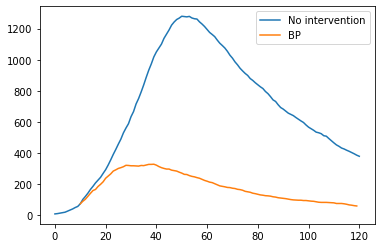

In [12]:
plt.plot(db.index, db.I, label="No intervention")
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"], label=k)
plt.legend()

In [13]:
##### MF SCENARIO #######
import imp
import scenario
imp.reload(scenario)
from scenario import Scenario
import ranking
imp.reload(ranking)
from ranking import RANKINGS
scenario_MF = Scenario(
    model, seed=seed+1, 
    ranking_options=dict(ranking=RANKINGS["backtrack"], 
                         algo="MF", init="all_S", tau=MF_tau, delta=MF_delta,mu=mu,lamb=lamb), 
    observation_options=observation_options,
    intervention_options=intervention_options,
)
scenario_MF.run(t_max-t1, print_every = 1)
print("Save MF strategy", flush=True)
#scenario_MF.counts.to_csv("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_MF_t%d_d%d.csv"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,MF_tau,MF_delta),
#                  index=False, sep="\t")
scenario_MF.save("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_MF_t%d_d%d_info"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,MF_tau,MF_delta))
cnts = scenario_MF.counts
cnts["t" ]=cnts.index
traces["MF"] = cnts
save_status(scenario_MF, "MF")

del scenario_MF
# 1h01min per round
print("End seed", flush=True)

Using ranking_backtrack to rank
Using seed=6
Selecting 0/2000 untracked individuals
t = 0 / 110
state: S:1921, I:75, R:4 I+R:79
obser: S:38, I:2, R:0, I+R:2
free birds: 73
obs_symp:0(0), obs_rank:2(2)
pos_rank:2, inf_cont:0.0
t = 1 / 110
state: S:1905, I:91, R:4 I+R:95
obser: S:74, I:6, R:0, I+R:6
free birds: 85
obs_symp:0(0), obs_rank:4(6)
pos_rank:4, inf_cont:0.0
t = 2 / 110
state: S:1893, I:103, R:4 I+R:107
obser: S:106, I:14, R:0, I+R:14
free birds: 89
obs_symp:0(0), obs_rank:8(14)
pos_rank:8, inf_cont:1.275
t = 3 / 110
state: S:1874, I:121, R:5 I+R:126
obser: S:138, I:22, R:0, I+R:22
free birds: 99
obs_symp:0(0), obs_rank:8(22)
pos_rank:8, inf_cont:2.55
t = 4 / 110
state: S:1854, I:138, R:8 I+R:146
obser: S:170, I:29, R:1, I+R:30
free birds: 109
obs_symp:0(0), obs_rank:7(29)
pos_rank:7, inf_cont:3.3
t = 5 / 110
state: S:1836, I:153, R:11 I+R:164
obser: S:198, I:38, R:4, I+R:42
free birds: 116
obs_symp:0(0), obs_rank:9(38)
pos_rank:9, inf_cont:1.95
t = 6 / 110
state: S:1825, I:160,

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


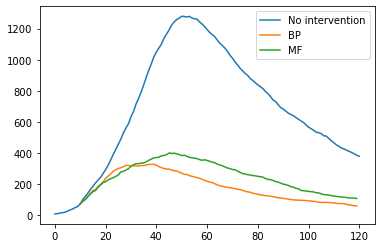

In [14]:
plt.plot(np.array(db.index), db.I.to_numpy(), label="No intervention")
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"], label=k)
plt.legend()

In [15]:
##### CT SCENARIO #######
import imp
import scenario
imp.reload(scenario)
from scenario import Scenario
import ranking
imp.reload(ranking)
from ranking import RANKINGS
scenario_CT = Scenario(
    model, seed=seed+1, 
    ranking_options=dict(ranking=RANKINGS["tracing"], 
                         algo="CT", init="all_S", tau=MF_tau, delta=MF_delta,mu=mu,lamb=lamb), 
    observation_options=observation_options,
    intervention_options=intervention_options,
)
scenario_CT.run(t_max-t1, print_every = 1)
print("Save MF strategy", flush=True)
#scenario_MF.counts.to_csv("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_MF_t%d_d%d.csv"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,MF_tau,MF_delta),
#                  index=False, sep="\t")
scenario_CT.save("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_CT_t%d_d%d_info"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,MF_tau,MF_delta))
cnts = scenario_CT.counts
cnts["t" ]=cnts.index
traces["CT"] = cnts
save_status(scenario_CT, "CT")
del scenario_CT
# 1h01min per round
print("End seed", flush=True)

Using ranking_tracing to rank
Using seed=6
Selecting 0/2000 untracked individuals
t = 0 / 110
state: S:1921, I:75, R:4 I+R:79
obser: S:38, I:2, R:0, I+R:2
free birds: 73
obs_symp:0(0), obs_rank:2(2)
pos_rank:2, inf_cont:0.0
t = 1 / 110
state: S:1907, I:89, R:4 I+R:93
obser: S:75, I:5, R:0, I+R:5
free birds: 84
obs_symp:0(0), obs_rank:3(5)
pos_rank:3, inf_cont:0.025
t = 2 / 110
state: S:1894, I:102, R:4 I+R:106
obser: S:114, I:6, R:0, I+R:6
free birds: 96
obs_symp:0(0), obs_rank:1(6)
pos_rank:1, inf_cont:0.05
t = 3 / 110
state: S:1873, I:122, R:5 I+R:127
obser: S:148, I:12, R:0, I+R:12
free birds: 110
obs_symp:0(0), obs_rank:6(12)
pos_rank:6, inf_cont:0.175
t = 4 / 110
state: S:1854, I:138, R:8 I+R:146
obser: S:186, I:14, R:0, I+R:14
free birds: 124
obs_symp:0(0), obs_rank:2(14)
pos_rank:2, inf_cont:0.05
t = 5 / 110
state: S:1836, I:152, R:12 I+R:164
obser: S:204, I:34, R:2, I+R:36
free birds: 118
obs_symp:0(0), obs_rank:20(34)
pos_rank:20, inf_cont:2.225
t = 6 / 110
state: S:1820, I:16

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


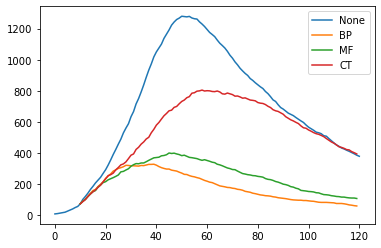

In [16]:
plt.plot(db.index.to_numpy(), db.I.to_numpy(), label="None")
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"], label=k)
plt.legend()

Text(0, 0.5, '$I+R$')

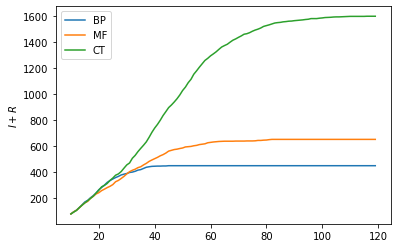

In [20]:
#plt.plot(db.index.to_numpy(), db.I.to_numpy()+db.R.to_numpy(), label="None")
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"]+traces[k]["R"], label=k)
plt.legend()
plt.ylabel("$I+R$")

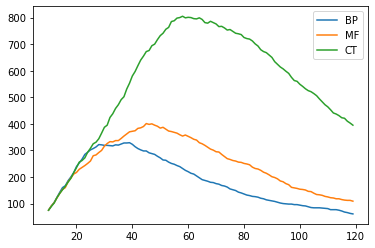

In [21]:
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"], label=k)
plt.legend()

In [22]:
db.index.to_numpy()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120])

In [23]:
import matplotlib.colors as matcolor

In [24]:
STATES_CONV={"S":0, "I":1, "R":2, "Q":6}

def get_nodes_status(time):
    if time < t1:
        return {k:np.where(all_states[time]==i)[0] 
                  for k, i in STATES_CONV.items()}

    x = status[status.t==time]
    out={}
    quar = (x.q==1)
    out["Q"] = (x[quar].i).values
    out["S"] = (x[(x.s==0)].i).values
    nq = np.logical_not(quar)
    out["I"] = (x[(x.s==1) & nq].i).values
    out["R"] = (x[(x.s==2)].i).values
    return out

In [25]:
def setup_start(ax, pos_nodes, nodes_keys, colors, fn_get_nodes):

    nodes_idx = fn_get_nodes(0)
    paths = {}
    for nk, color in zip(nodes_keys, colors):
        g=pos_nodes.iloc[nodes_idx[nk]]
        paths[nk] = ax.scatter(g["x"],g["y"],color=color)
    return paths

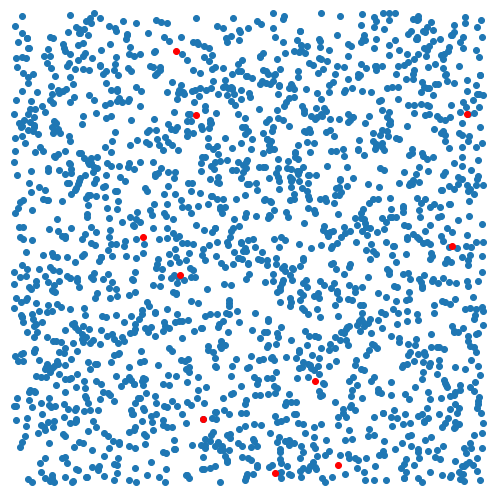

<Figure size 432x288 with 0 Axes>

In [26]:
from matplotlib.animation import FuncAnimation, PillowWriter


ALGO="CT"
fig,ax = plt.subplots(figsize=(7,7), frameon=False)
lim=0.6
ax.set(xlim=(pos_nodes.x.max()+lim, pos_nodes.x.min()-lim),
      ylim=(pos_nodes.y.max()+lim, pos_nodes.y.min()-lim))

#fig.patch.set_visible(False)
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
time = 0
status=ranks_status[ALGO].convert_dtypes()

st_val= ["S","I","Q","R"]

paths = setup_start(ax, pos_nodes, st_val, colors=[None, "red","violet","yellowgreen"],
                   fn_get_nodes=get_nodes_status)

def animate(time):
    if time >= T:
        time = T-1
    nodes_idx = get_nodes_status(time)
    for k in st_val:
        g=pos_nodes.iloc[nodes_idx[k]]
        paths[k].set_offsets(np.c_[g["x"].values, g["y"].values])
    plt.draw()

anim = FuncAnimation(
    fig, animate, interval=100, frames=T+20, cache_frame_data=False)

plt.draw()
plt.show()

#anim.save("sim.mov", codec="h263p", bitrate=-1)
#anim.save(f"sim_{ALGO}.webm", codec="libvpx-vp9")
writer=PillowWriter(fps=15)
anim.save(f"sim_{ALGO}.gif",writer=writer)

In [27]:
STATES_CONV={"S":0, "I":1, "R":2, "Q":6}

def get_nodes_ranker(time,status=None):
    if time < t1:
        return {k:np.where(all_states[time]==i)[0] 
                  for k, i in STATES_CONV.items()}

    x = status[status.t==time]
    out={}
    quar = (x.q==1)
    out["Q"] = (x[quar].i).values
    out["S"] = (x[(x.s==0)].i).values
    nq = np.logical_not(quar)
    out["I"] = (x[(x.s==1) & nq].i).values
    out["R"] = (x[(x.s==2)].i).values
    return out

In [87]:
def setup_start_all(ax, pos_nodes,status, nodes_keys, colors, fn_get_nodes):

    nodes_idx = fn_get_nodes(0, status)
    paths = {}
    for nk, color in zip(nodes_keys, colors):
        g=pos_nodes.iloc[nodes_idx[nk]]
        paths[nk] = ax.scatter(g["x"],g["y"],color=color)
    return paths

In [30]:

statuses={a:ranks_status[a].convert_dtypes() for a in ranks_status.keys()}

st_val= ["S","I","Q","R"]
def get_nodes(t):
    return {i:np.where(all_states[t]==i)[0] for i in range(3)}
def setup_start(ax, pos_nodes, nodes_keys, colors, fn_get_nodes):

    nodes_idx = fn_get_nodes(0)
    paths = {}
    for nk, color in zip(nodes_keys, colors):
        g=pos_nodes.iloc[nodes_idx[nk]]
        paths[nk] = ax.scatter(g["x"],g["y"], color=color)
    return paths





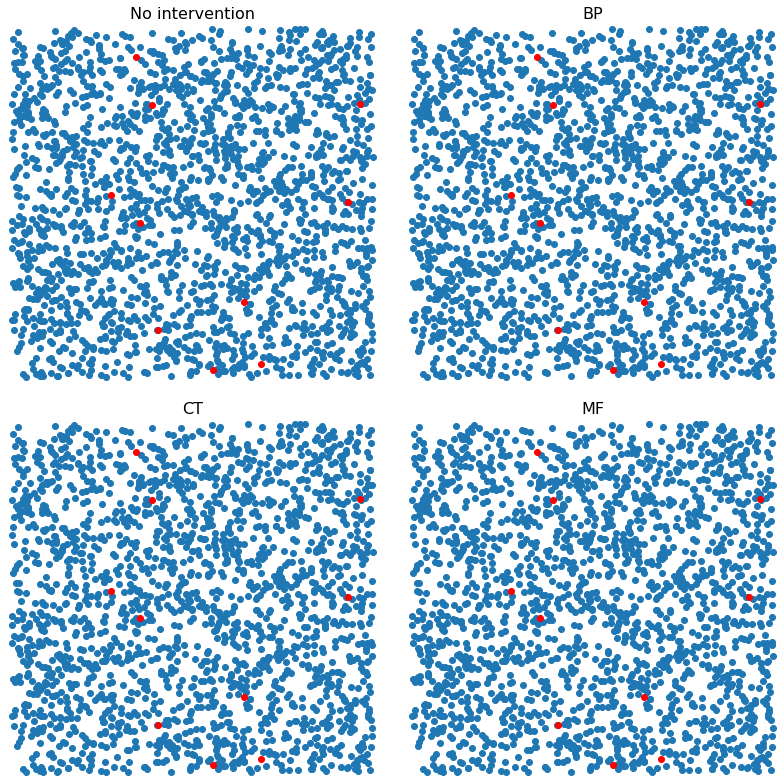

<Figure size 432x288 with 0 Axes>

In [32]:
from matplotlib.animation import FuncAnimation, PillowWriter

TITLES = ["No intervention", "BP", "CT", "MF"]
ALGO="CT"
plt.rc('axes', titlesize=16) 

fig,axes = plt.subplots(2,2,figsize=(11,11), frameon=False)
lim=0.6
axes = axes.flatten()
for ax,tit in zip(axes, TITLES):
    ax.set(xlim=(pos_nodes.x.max()+lim, pos_nodes.x.min()-lim),
      ylim=(pos_nodes.y.max()+lim, pos_nodes.y.min()-lim))

#fig.patch.set_visible(False)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(tit)
plt.tight_layout(h_pad=2., w_pad=3.)
axes_rankers = {"BP": axes[1], "CT": axes[2], "MF": axes[3]}
paths = {k: setup_start_all(ax, pos_nodes, statuses[k],
                    st_val, colors=[None, "red","violet","limegreen"],
                   fn_get_nodes=get_nodes_ranker) for k, ax in axes_rankers.items()}
paths_No = setup_start(axes[0], pos_nodes,  [0,1,2], colors=[None, "red","limegreen"],
                   fn_get_nodes=get_nodes)
def animate(time):
    if time >= T:
        time = T-1
        
    nodes_idx = get_nodes(time)
    for k in [0,1,2]:
        g=pos_nodes.iloc[nodes_idx[k]]
        paths_No[k].set_offsets(np.c_[g["x"].values, g["y"].values])

        
    for rank in axes_rankers.keys():
        
        nodes_idx = get_nodes_ranker(time, statuses[rank])
        for k in st_val:
            g=pos_nodes.iloc[nodes_idx[k]]
            paths[rank][k].set_offsets(np.c_[g["x"].values, g["y"].values])
    plt.draw()

anim = FuncAnimation(
    fig, animate, interval=100, frames=T+40, cache_frame_data=False)

plt.draw()
plt.show()


anim.save("sim_all.mp4", codec="mpeg4", bitrate=-1, dpi=160)
#anim.save(f"sim_all.webm", codec="libvpx-vp9", dpi=160)
#anim.save(f"sim_all.mkv", codec="yuv4", dpi=160)

#writer=PillowWriter(fps=15)
#anim.save(f"sim_all.gif",writer=writer)

In [84]:
STATES_CONV={"S":0, "I":1, "R":2, "Q":6}
def get_nodes_SI(t):
    out = {}
    out["S"] = np.where(all_states[t]==0)[0]
    out["I"] = np.where(all_states[t]!=0)[0]
    return out#{i:np.where(all_states[t]==i)[0] for i in range(3)}

def get_nodes_ranker_SI(time,status=None):
    if time < t1:
        r = get_nodes_SI(time)
        r.update({"Q":[]})
        return r
    x = status[status.t==time]
    out={}
    quar = (x.q==1)
    out["Q"] = (x[quar].i).values
    out["S"] = (x[(x.s==0)].i).values
    nq = np.logical_not(quar)
    out["I"] = (x[(x.s==1) | (x.s==2)].i).values
    #out["R"] = (x[(x.s==2)].i).values
    return out



In [92]:
import matplotlib

In [125]:
def setup_circles(ax, pos_nodes,status, nodes_keys, colors_in, colors_out, fn_get_nodes):

    nodes_idx = fn_get_nodes(0, status)
    paths = {}
    for nk, col_in, col_out in zip(nodes_keys, colors_in, colors_out):
        g=pos_nodes.iloc[nodes_idx[nk]]
        paths[nk] = ax.scatter(g["x"],g["y"],facecolors=col_in, edgecolors=col_out)
    return paths

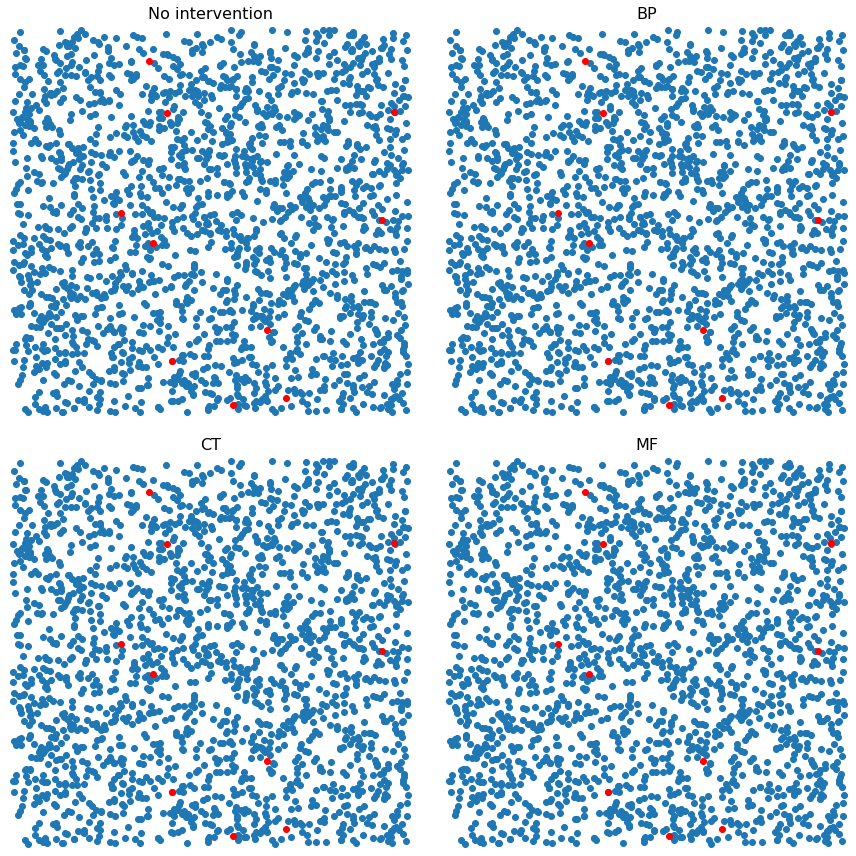

<Figure size 432x288 with 0 Axes>

In [126]:
from matplotlib.animation import FuncAnimation, PillowWriter

TITLES = ["No intervention", "BP", "CT", "MF"]
st_val = ["S","I"]
st_circles = ["Q"]
plt.rc('axes', titlesize=16)

fig,axes = plt.subplots(2,2,figsize=(12,12), frameon=False)
lim=0.6
axes = axes.flatten()
for ax,tit in zip(axes, TITLES):
    ax.set(xlim=(pos_nodes.x.max()+lim, pos_nodes.x.min()-lim),
      ylim=(pos_nodes.y.max()+lim, pos_nodes.y.min()-lim))

#fig.patch.set_visible(False)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(tit)
plt.tight_layout(h_pad=2., w_pad=3.)
axes_rankers = {"BP": axes[1], "CT": axes[2], "MF": axes[3]}
paths = {k: setup_start_all(ax, pos_nodes, statuses[k],
                    st_val, colors=[None, "red","forestgreen"],
                   fn_get_nodes=get_nodes_ranker_SI) for k, ax in axes_rankers.items()}
paths_No = setup_start(axes[0], pos_nodes,  ["S","I"], colors=[None, "red", "forestgreen"],
                   fn_get_nodes=get_nodes_SI)
## circles
paths_circles = {k: setup_circles(ax, pos_nodes, statuses[k],
                    st_circles, colors_in=["red"], colors_out=["black"],
                   fn_get_nodes=get_nodes_ranker_SI) 
                 for k, ax in axes_rankers.items()}
def animate(time):
    if time >= T:
        time = T-1
        
    nodes_idx = get_nodes_SI(time)
    for k in ["S","I"]:
        g=pos_nodes.iloc[nodes_idx[k]]
        paths_No[k].set_offsets(np.c_[g["x"].values, g["y"].values])

        
    for rank in axes_rankers.keys():
        
        nodes_idx = get_nodes_ranker_SI(time, statuses[rank])
        for k in st_val:
            g=pos_nodes.iloc[nodes_idx[k]]
            paths[rank][k].set_offsets(np.c_[g["x"].values, g["y"].values])
        for k in st_circles:
            g=pos_nodes.iloc[nodes_idx[k]]
            paths_circles[rank][k].set_offsets(np.c_[g["x"].values, g["y"].values])
        
    plt.draw()

anim = FuncAnimation(
    fig, animate, interval=100, frames=T+40, cache_frame_data=False)

plt.draw()
plt.show()


anim.save("sim_circle.mp4", codec="mpeg4", bitrate=-1, dpi=160)
#anim.save(f"sim_all.webm", codec="libvpx-vp9", dpi=160)
#anim.save(f"sim_all.mkv", codec="yuv4", dpi=160)

#writer=PillowWriter(fps=15)
#anim.save(f"sim_all.gif",writer=writer)

In [ ]:
##### TRACING SCENARIO #######
scenario_trac = Scenario( model, seed=seed+1, 
    ranking_options=dict(ranking=RANKINGS["tracing"], tau=trac_tau),
    observation_options=observation_options,
    intervention_options=intervention_options
)
scenario_trac.run(t_max-t1, print_every = 1)
print("Save tracing strategy", flush=True)
#scenario_trac.counts.to_csv("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_trac_t%d.csv"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,trac_tau),
#                  index=False, sep="\t")
scenario_trac.save("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_trac_t%d_info"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,trac_tau))

del scenario_trac

In [ ]:
## CT 2

In [17]:
import imp
import scenario
imp.reload(scenario)
from scenario import Scenario
##### TRACING UP TO SECOND NN #######
scenario_trac_2nd = Scenario( model, seed=seed+1, 
    ranking_options=dict(ranking=RANKINGS["tracing2nd"], tau=trac_tau, lamb=trac_lambd, save=True),
    observation_options=observation_options,
    intervention_options=intervention_options
)
scenario_trac_2nd.run(t_max-t1, print_every = 1)
print("Save tracing sec NN strategy", flush=True)
#scenario_trac_2nd.counts.to_csv("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_trac2nd_t%d.csv"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,trac_tau),
   #               index=False, sep="\t")

scenario_trac_2nd.save("csv/Proximity_N%dK_T%d_s1_ti%d_pz%d_mu%.2f_l%.2f_seed%d_obs%d_trac2nd_t%d_info"%(N/1000,T,t1,N_patient_zero,mu,lamb,seed,n_ranking,trac_tau))
cnts = scenario_trac_2nd.counts
cnts["t" ]=cnts.index
traces["CT2"] = cnts
save_status(scenario_trac_2nd, "CT2")
del scenario_trac_2nd
print("End seed", flush=True)

Using ranking_tracing_secnn to rank
Using seed=6
Selecting 0/2000 untracked individuals
t = 0 / 110
state: S:1921, I:75, R:4 I+R:79
obser: S:38, I:2, R:0, I+R:2
free birds: 73
obs_symp:0(0), obs_rank:2(2)
pos_rank:2, inf_cont:0.0
t = 1 / 110
state: S:1907, I:89, R:4 I+R:93
obser: S:75, I:5, R:0, I+R:5
free birds: 84
obs_symp:0(0), obs_rank:3(5)
pos_rank:3, inf_cont:0.025
t = 2 / 110
state: S:1894, I:102, R:4 I+R:106
obser: S:114, I:6, R:0, I+R:6
free birds: 96
obs_symp:0(0), obs_rank:1(6)
pos_rank:1, inf_cont:0.05
t = 3 / 110
state: S:1873, I:122, R:5 I+R:127
obser: S:148, I:12, R:0, I+R:12
free birds: 110
obs_symp:0(0), obs_rank:6(12)
pos_rank:6, inf_cont:0.175
t = 4 / 110
state: S:1854, I:138, R:8 I+R:146
obser: S:186, I:14, R:0, I+R:14
free birds: 124
obs_symp:0(0), obs_rank:2(14)
pos_rank:2, inf_cont:0.05
Appeding contacts, t=5
Appeding contacts, t=4
Appeding contacts, t=3
Appeding contacts, t=2
Appeding contacts, t=1
Appeding contacts, t=0
first NN c: 230. second NN c: 3241
t = 5 

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


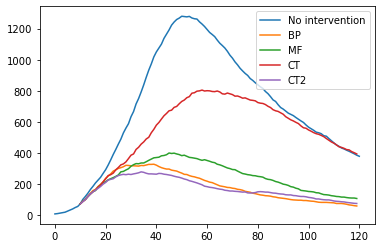

In [18]:
plt.plot(np.array(db.index), db.I, label="No intervention")
for k in traces:
    plt.plot(traces[k]["t"]+t1,traces[k]["I"], label=k)
plt.legend()